In [33]:
# import required libraries
import praw
from IPython import display
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sns.set(style='darkgrid')

In [2]:
reddit = praw.Reddit(client_id='vm4lkJvkhWM00FjppcHjPA',
                     client_secret='m2-rS76QQV22MAUv2E7bB0YzRA0U4w',
                     user_agent='MrKimhof')

Version 7.5.0 of praw is outdated. Version 7.6.1 was released 5 days ago.


In [3]:
# define set for headlines
# set removes chances of getting duplicate headlines
headlines = set()

In [4]:
# for each post is the /r/politics subreddit, iterate through and extract the headlines
for post in reddit.subreddit('politics').new(limit=None):
    headlines.add(post.title)
    display.clear_output()
    print(len(headlines))

992


In [5]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\taylo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taylo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# use vader SIA to rank each portion of the text as positive, negative, or neutral

# create new sia object
sia = SIA()
results = [] # empty to list to append calculated polarity scores

# iterate through each headline in set and append to results list
for headline in headlines:
    polarity = sia.polarity_scores(headline)
    polarity['headlines'] = headline
    results.append(polarity)

# print results to ensure scores encoded properly
pprint(results[:5], width=75)

[{'compound': 0.4215,
  'headlines': 'Democrats to maintain control of the United States Senate',
  'neg': 0.0,
  'neu': 0.741,
  'pos': 0.259},
 {'compound': 0.0,
  'headlines': 'Audio shows interim Uvalde police chief knew about room '
               '‘full of victims’ during Robb Elementary shooting, CNN '
               'reports',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.0,
  'headlines': 'What Mitch McConnell nailed about the 2022 Senate races | '
               'CNN Politics',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.0,
  'headlines': 'It’s official: Florida is a red state',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': -0.1027,
  'headlines': 'How the fall of Roe shattered Republicans’ midterm dreams',
  'neg': 0.242,
  'neu': 0.547,
  'pos': 0.211}]


In [7]:
# create pandas dataframe from records create in previous step
df = pd.DataFrame.from_records(results)
df.head() # display first five obs to ensure data loaded properly

,neg,neu,pos,compound,headlines
0,0.000,0.741,0.259,0.4215,Democrats to maintain control of the United St...
1,0.000,1.000,0.000,0.0000,Audio shows interim Uvalde police chief knew a...
2,0.000,1.000,0.000,0.0000,What Mitch McConnell nailed about the 2022 Sen...
3,0.000,1.000,0.000,0.0000,It’s official: Florida is a red state
4,0.242,0.547,0.211,-0.1027,How the fall of Roe shattered Republicans’ mid...


In [8]:
# create new label column and encode:
#    0: neutral
#    1: positive (compound > +0.2)
#   -1: negative (compound < -0.2)
df['label'] = 0
df.loc[df.compound == 0, 'label'] = 0
df.loc[df.compound > 0.2, 'label'] = 1.0
df.loc[df.compound < -0.2, 'label'] = -1

# display first five obs to ensure new column added properly
df.head()

,neg,neu,pos,compound,headlines,label
0,0.000,0.741,0.259,0.4215,Democrats to maintain control of the United St...,1.0
1,0.000,1.000,0.000,0.0000,Audio shows interim Uvalde police chief knew a...,0.0
2,0.000,1.000,0.000,0.0000,What Mitch McConnell nailed about the 2022 Sen...,0.0
3,0.000,1.000,0.000,0.0000,It’s official: Florida is a red state,0.0
4,0.242,0.547,0.211,-0.1027,How the fall of Roe shattered Republicans’ mid...,0.0


In [9]:
# create new df with just target label and headline feature
df2 = df[['headlines', 'label']]

In [36]:
!pip uninstall snappy python-snappy

^C


In [30]:
df2.to_csv('labeled_reddit_comments.csv')

AttributeError: module 'fsspec' has no attribute 'utils'

## Dataset Overview and EDA

In [10]:
# view samples of positive and negative headlines
print('Below are some samples of positive headlines:\n')
pprint(list(df[df['label'] == 1].headlines)[:5], width=75)

print('\n\n' + '*' * 75 + '\n\n')

print('Below are some samples of negative headlines:\n')
pprint(list(df[df['label'] == -1].headlines)[:5], width=75)

Below are some samples of positive headlines:

['Democrats to maintain control of the United States Senate',
 'MAGA Republicans scheme to shiv Kevin McCarthy’s speaker bid unless he '
 'agrees to their demands: Freedom Caucus has a two-step plan to keep the '
 'Californian Republican from the most influential role in Congress',
 'Nevada voters are about to pass the most comprehensive LGBTQ rights '
 'amendment in the nation',
 'Senate advances Respect for Marriage Act in bipartisan 62-37 vote',
 'Both parties gear up for Georgia Senate runoff with eyes on Arizona and '
 'Nevada']


***************************************************************************


Below are some samples of negative headlines:

['Jan. 6 committee staffers told preliminary plan for final report would '
 'focus largely on Trump, not on law enforcement failures, sources say',
 'There’s a Lot Congress Can Do Now, and It Starts With Changing a Law '
 'That Trump Exploited',
 'Biden’s student-debt con job fooled Ge

In [11]:
# check amount of positive, negative, and neutral headlines are measured in the dataset
print(df['label'].value_counts()) # total count
print(df['label'].value_counts(normalize=True) * 100) # representation as a proportion of the data

 0.0    450
-1.0    313
 1.0    229
Name: label, dtype: int64
 0.0    45.362903
-1.0    31.552419
 1.0    23.084677
Name: label, dtype: float64


Nearly 1/2 of the headlines have been encoded as `neutral`, while approximately 32% of the headlines are `negative`. The remaining 24% are `positive`

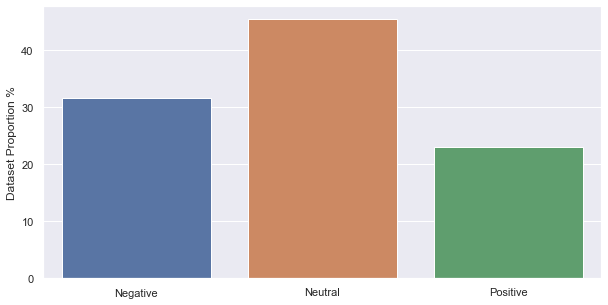

In [12]:
# view the same info as a bar chart visualization
fig, ax = plt.subplots(figsize=(10,5))

counts = df['label'].value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel('Dataset Proportion %')

plt.show()

So, something to keep in mind as the project progresses is that the dataset is quite biases towards `neutral` rating score

## Tokenizing The Data and Accounting For Stopwords

In [13]:
# create tokens for each record so that it can be more easily understood by a machine
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

# create new regular expression tokenizer object
tokenizer = RegexpTokenizer(r'\w+')

# create new stopwords object
stop_words = stopwords.words('english')

In [14]:
# utility function that takes headlines as input, and returns clean "tokens"
def tokenize_and_remove_stopwords(headlines):
    tokens = [] # init empty list to append new tokens

    # iterate through each headline and create token and remove stopwords
    for headline in headlines:
        token = tokenizer.tokenize(headline)
        token = [t.lower() for t in token if t.lower() not in stop_words]
        tokens.extend(token)

    return tokens

In [15]:
# extract common words from positive headlines using freqdist function
positive_headlines = list(df[df['label'] == 1].headlines)

# extract tokens using utility function
positive_tokens = tokenize_and_remove_stopwords(positive_headlines)
positive_frequency = nltk.FreqDist(positive_tokens)

# display most common positive tokens
positive_frequency.most_common(15)

[('democrats', 41),
 ('senate', 39),
 ('trump', 38),
 ('arizona', 30),
 ('wins', 30),
 ('win', 29),
 ('election', 21),
 ('supreme', 20),
 ('court', 20),
 ('gop', 20),
 ('house', 19),
 ('biden', 18),
 ('party', 17),
 ('republican', 15),
 ('race', 14)]